In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
import keras
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


print(tf.__version__)

2.15.0


# 新段落

Loading Dataset

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/animals/"


data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)


df = pd.DataFrame(data)

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

split the dataset into train & test

In [ ]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath        labels
0  /content/drive/MyDrive/Colab Notebooks/animals...           owl
1  /content/drive/MyDrive/Colab Notebooks/animals...   caterpillar
2  /content/drive/MyDrive/Colab Notebooks/animals...  hippopotamus
3  /content/drive/MyDrive/Colab Notebooks/animals...           bee
4  /content/drive/MyDrive/Colab Notebooks/animals...          hare
(3779, 3)
--------Validation----------
                                             imgpath labels
0  /content/drive/MyDrive/Colab Notebooks/animals...    fly
1  /content/drive/MyDrive/Colab Notebooks/animals...    owl
2  /content/drive/MyDrive/Colab Notebooks/animals...  sheep
3  /content/drive/MyDrive/Colab Notebooks/animals...    pig
4  /content/drive/MyDrive/Colab Notebooks/animals...  eagle
(1134, 3)
----------Test--------------
                                             imgpath      labels
0  /content/drive/MyDrive/Colab Notebooks/animals...       snake
1

show sample from data

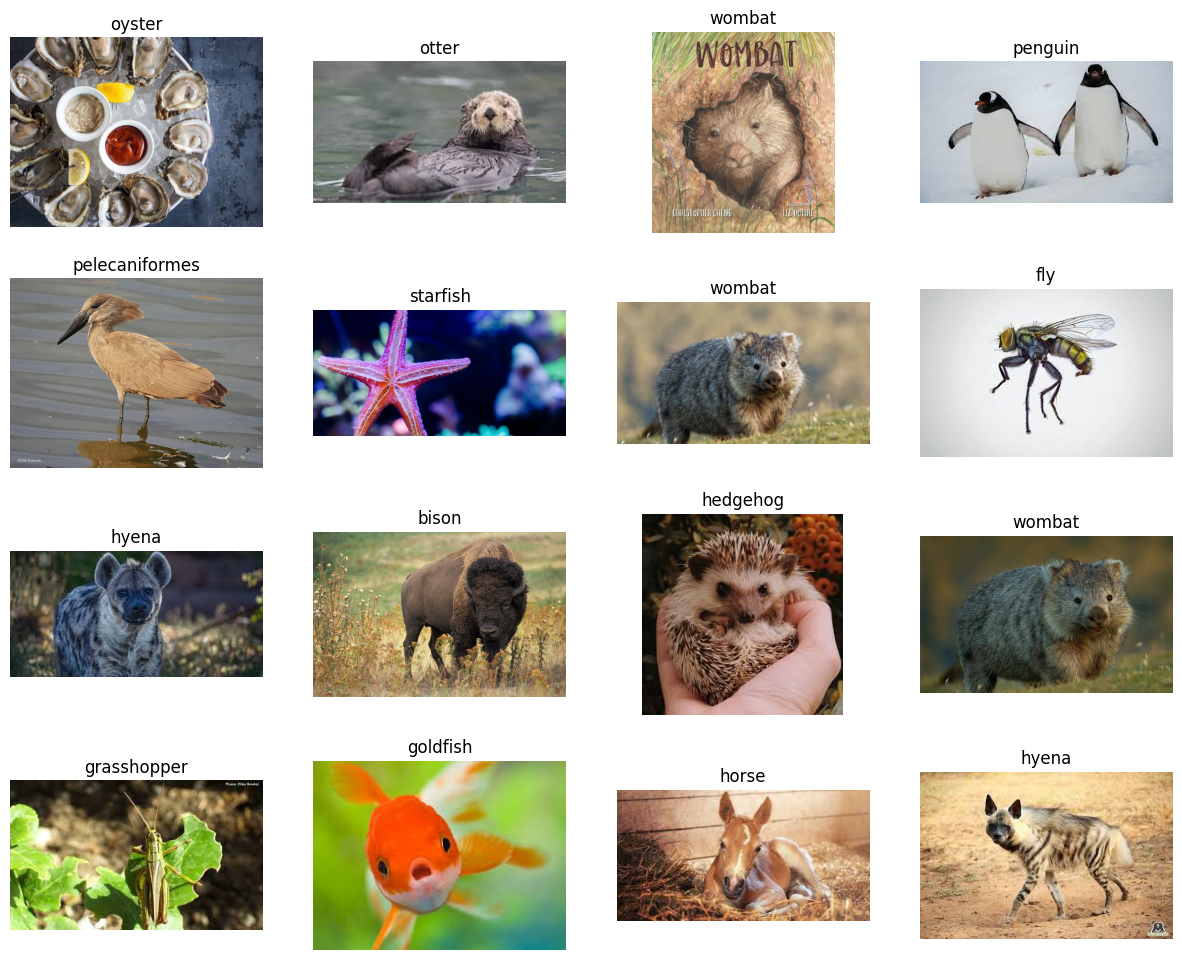

In [ ]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

creating dataloaders

In [ ]:
%%time

BATCH_SIZE = 15
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 3779 validated image filenames belonging to 90 classes.
Found 1134 validated image filenames belonging to 90 classes.
Found 487 validated image filenames belonging to 90 classes.
CPU times: user 115 ms, sys: 201 ms, total: 317 ms
Wall time: 1.08 s


model structure

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB3(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

43941136/43941136 [==============================] - 1s 0us/step


In [ ]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.15),
  layers.experimental.preprocessing.RandomZoom(0.15),
  layers.experimental.preprocessing.RandomContrast(0.15),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024  

training: transfer training

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 10 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
252/252 [==============================] - 2471s 10s/step - loss: 2.6300 - accuracy: 0.4409 - val_loss: 0.8484 - val_accuracy: 0.7981 - lr: 5.0000e-04
Epoch 2/10
252/252 [==============================] - 49s 197ms/step - loss: 1.0385 - accuracy: 0.7658 - val_loss: 0.5171 - val_accuracy: 0.8668 - lr: 5.0000e-04
Epoch 3/10
252/252 [==============================] - 49s 195ms/step - loss: 0.7440 - accuracy: 0.8161 - val_loss: 0.4389 - val_accuracy: 0.8818 - lr: 5.0000e-04
Epoch 4/10
252/252 [==============================] - 49s 193ms/step - loss: 0.5915 - accuracy: 0.8590 - val_loss: 0.3812 - val_accuracy: 0.8951 - lr: 5.0000e-04
Epoch 5/10
252/252 [==============================] - 50s 197ms/step - loss: 0.5063 - accuracy: 0.8793 - val_loss: 0.3872 - val_accuracy: 0.8986 - lr: 5.0000e-04
Epoch 6/10
252/252 [==============================] - 49s 194ms/step - loss: 0.4064 - accuracy: 0.9045 - val_loss: 0.5713 - val_accuracy: 0.8633 - lr: 5.0000e-04
Epoch 7/10
252/252 [========

display model performance

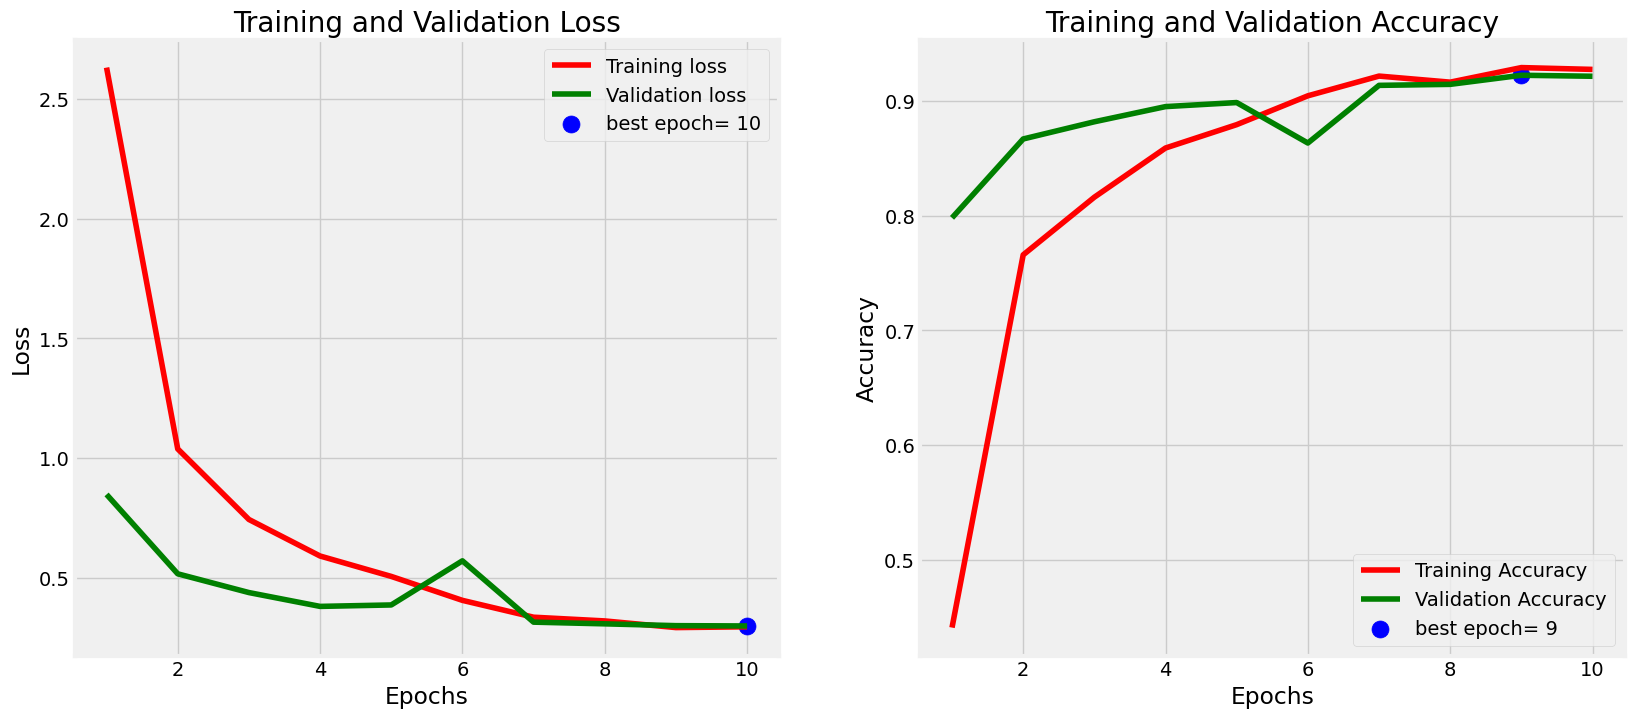

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

Training : Fine Tuning

In [ ]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False

# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

input_1 True
rescaling True
normalization True
rescaling_1 True
stem_conv_pad True
stem_conv True
stem_bn False
stem_activation True
block1a_dwconv True
block1a_bn False
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, None, None, None   0         
 ial)                        )                                   
                                                                 
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 activation (Activation

Display model performance

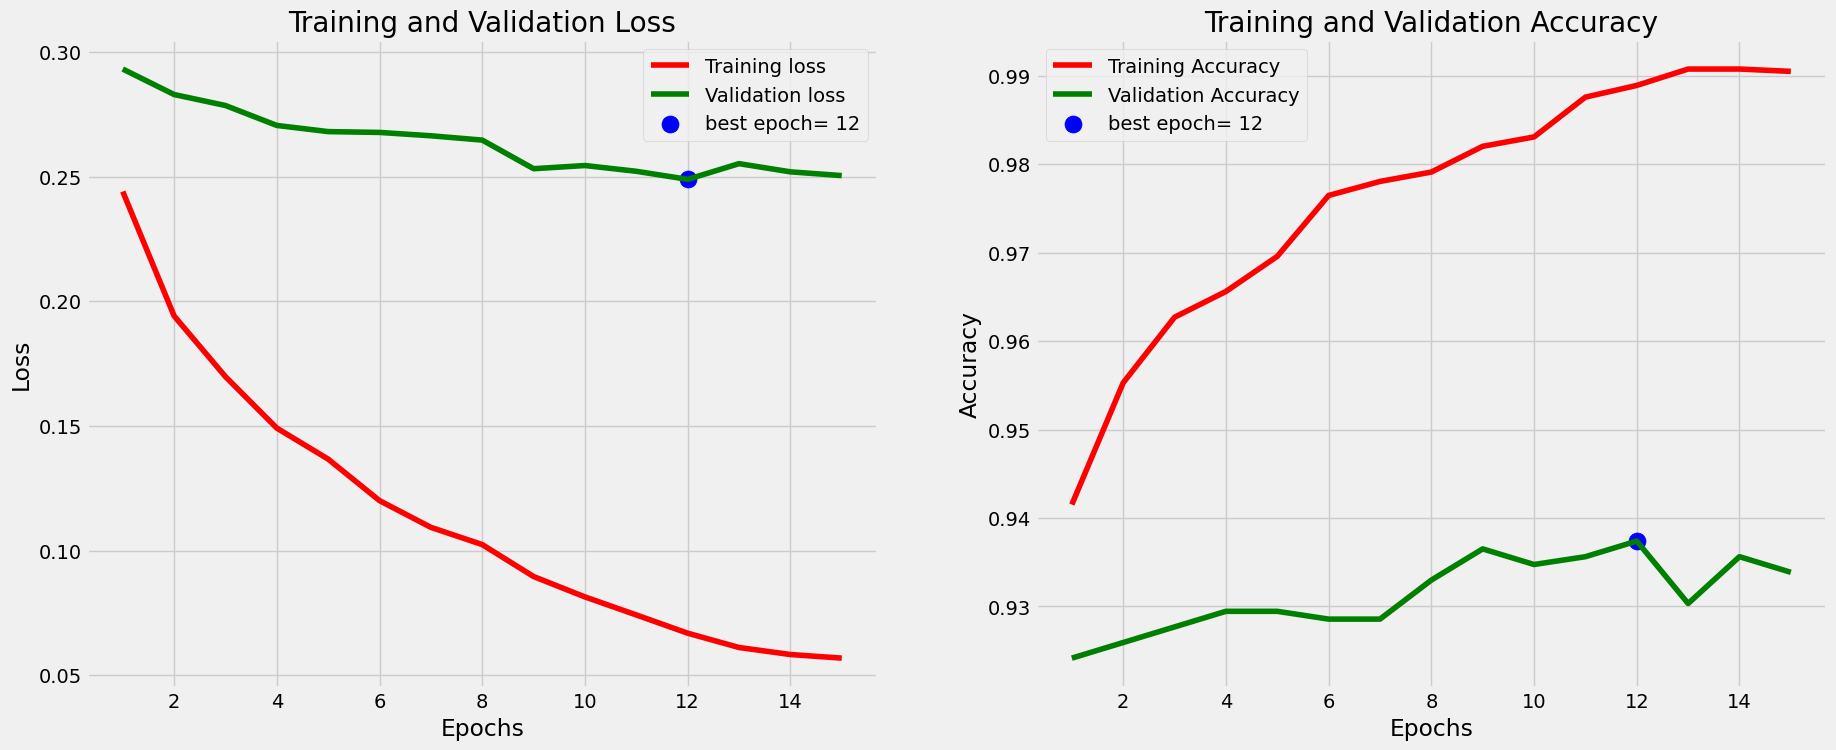

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

model.evaluate

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.25802
Test Accuracy: 93.63%


F1 Score / Recall / Precision¶

In [ ]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

33/33 [==============================] - 8s 154ms/step
F1 Score: 0.9304066041553142
                precision    recall  f1-score   support

      antelope       1.00      1.00      1.00         4
        badger       1.00      1.00      1.00         8
           bat       0.50      0.33      0.40         3
          bear       1.00      0.75      0.86         4
           bee       0.86      1.00      0.92         6
        beetle       1.00      1.00      1.00         8
         bison       1.00      1.00      1.00         7
          boar       0.89      0.89      0.89         9
     butterfly       1.00      1.00      1.00         7
           cat       1.00      1.00      1.00         5
   caterpillar       1.00      1.00      1.00         4
    chimpanzee       1.00      1.00      1.00         4
     cockroach       1.00      1.00      1.00         5
           cow       0.78      1.00      0.88         7
        coyote       0.80      1.00      0.89         4
          crab     

Get Predictions

In [ ]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

33/33 [==============================] - 5s 155ms/step


Image Index  Test Labels Test Classes  Prediction Labels  \
0            0           76        snake                 76   
1            1           88   woodpecker                 88   
2            2            7         boar                  7   
3            3           83       turkey                 83   
4            4           63          pig                 63   
5            5           66       possum                 66   
6            6           34         hare                 34   
7            7           62      penguin                 62   

  Prediction Classes                                               Path  \
0              snake  /content/drive/MyDrive/Colab Notebooks/animals...   
1         woodpecker  /content/drive/MyDrive/Colab Notebooks/animals...   
2               boar  /content/drive/MyDrive/Colab Notebooks/animals...   
3             turkey  /content/drive/MyDrive/Colab Notebooks/animals...   
4                pig  /content/drive/MyDrive/Colab Notebooks/animals...   
5             possum  /content/drive/MyDrive/Colab Notebooks/animals...   
6               hare  /content/drive/MyDrive/Colab Notebooks/animals...   
7            penguin  /content/drive/MyDrive/Colab Notebooks/animals...   

   Prediction Probability  
0                0.996825  
1                0.999709  
2                0.997163  
3                0.997794  
4                0.560256  
5                0.950485  
6                0.999547  
7                0.999964

Print the most confident errors

In [ ]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

Confusion Matrics and Classification Report

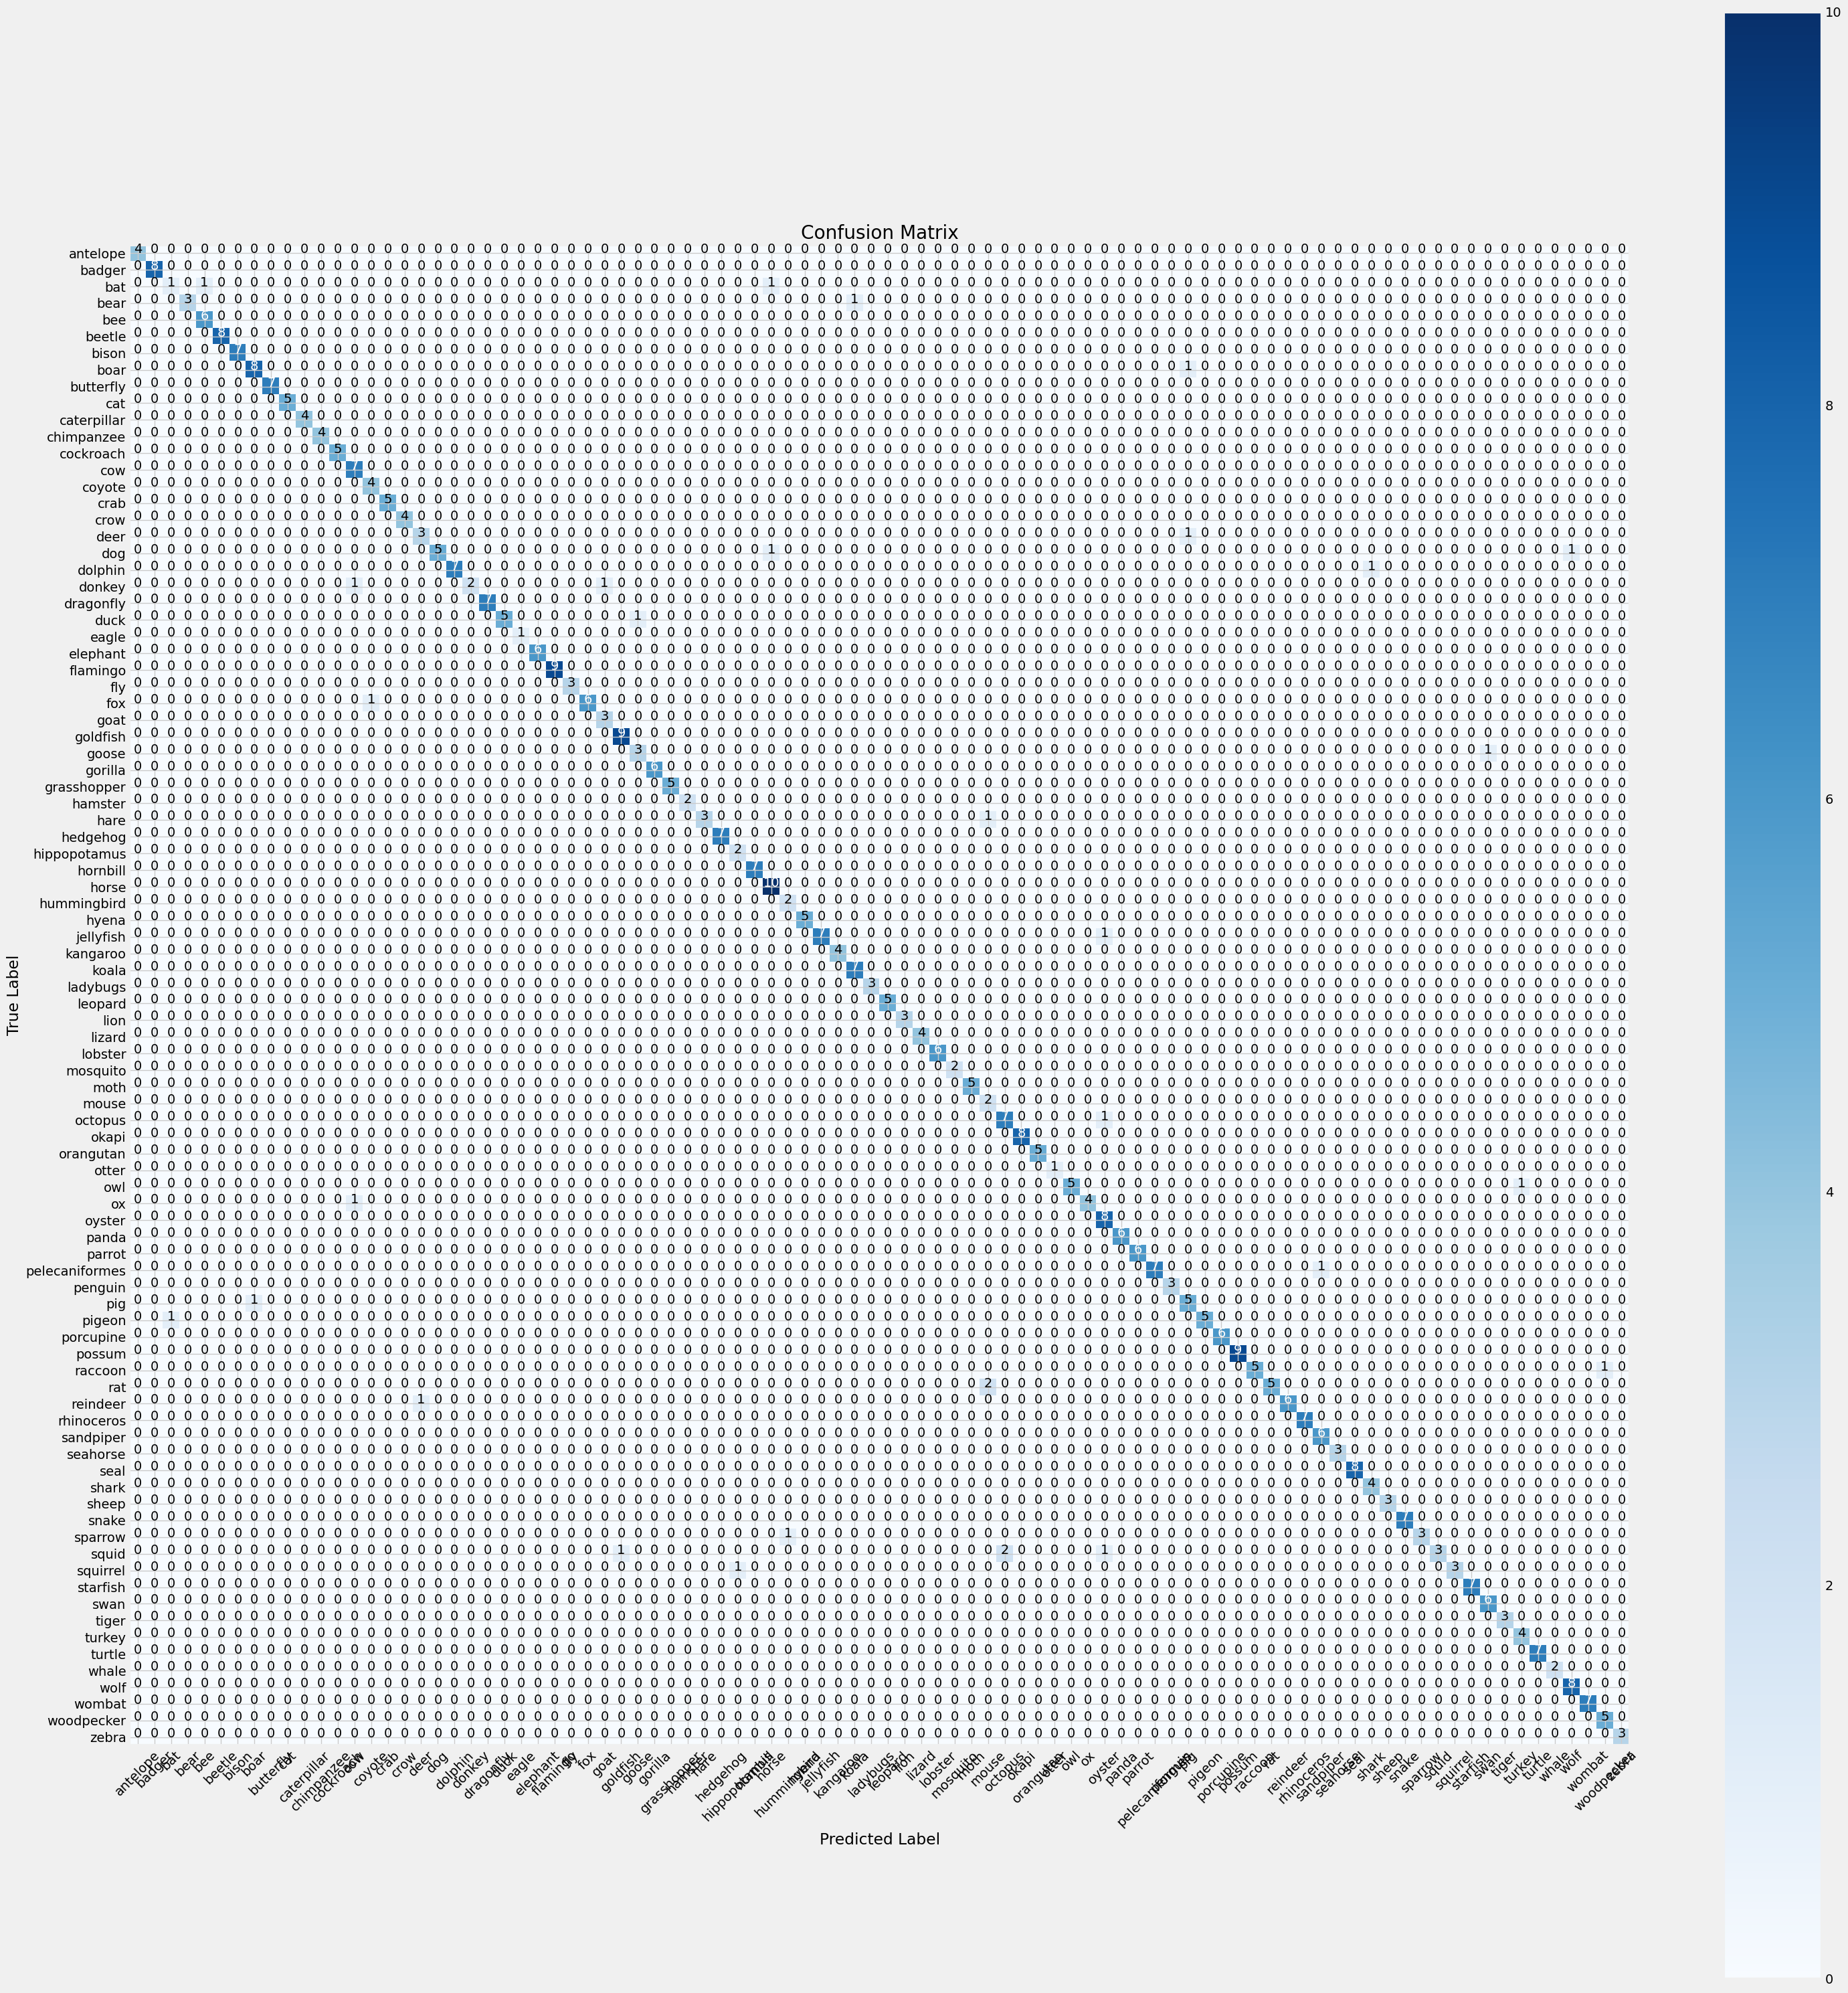

In [ ]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()